# Sentiment Analysis with BERT

This tutorial is adapted from [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) created by Venelin Valkov, and [Skim AI Fine tuning BERT Tutorial](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/) by Chris Tran.

In the previous part, we learned about Transformers and how they can be used for Sentiment Classification.

In this part of the tutorial, we will:

- Understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Transfer Learning to build our own Sentiment Classifier, using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

## Setup

We'll need several Python libraries which we will install first:

In [1]:
!pip install -q -U watermark

In [2]:
!pip install tqdm==4.43.0

     ---------------------------------------- 59.1/59.1 kB ? eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.4.0 requires tqdm>=4.62.1, but you have tqdm 4.43.0 which is incompatible.


In [3]:
!pip install -qq transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.4.0

numpy       : 1.23.0
pandas      : 1.4.3
torch       : 1.12.0+cu113
transformers: 4.20.1



In [5]:
from pprint import pprint

In [6]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import tqdm
import pandas as pd
pd.set_option('display.max_colwidth', None)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
!pip install datasets
from datasets import load_dataset

# Download ood datasets for sentiment classification

sst2_dataset = load_dataset("glue", "sst2")

  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.43.0
    Uninstalling tqdm-4.43.0:
      Successfully uninstalled tqdm-4.43.0

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


100%|██████████| 3/3 [00:00<00:00, 94.00it/s]                                          

Dataset glue downloaded and prepared to C:\Users\AI_15\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


In [8]:
!git clone https://github.com/acmi-lab/counterfactually-augmented-data

Cloning into 'counterfactually-augmented-data'...


In [9]:
!nvidia-smi

Fri Jul 29 11:40:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P8    15W /  N/A |   1476MiB /  8192MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

## Dataset for Sentiment Analysis: IMDB Movie Reviews
The original IMDb dataset consists of **50k reviews** divided equally across
train and test splits. To keep the task of editing from growing unwieldy, we filter out the longest 20%
of reviews, leaving 20k reviews in the train split from which we randomly sample 2.5k reviews,
enforcing a **50:50 class balance**.

Following revision by the crowd workers, we partition this dataset
into train/validation/test splits containing 1707, 245 and 488 examples, respectively.

In [10]:
# Let's see how the data files are organized
!find /content/counterfactually-augmented-data/sentiment/orig/ -name '*.tsv' | xargs wc -l
!find /content/counterfactually-augmented-data/sentiment/new/ -name '*.tsv' | xargs wc -l
!find /content/counterfactually-augmented-data/sentiment/combined/ -name '*.tsv' | xargs wc -l

'xargs'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'xargs'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'xargs'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [12]:
# We'll first use the original data, reading tab separated files into Pandas dataframes
orig_train = pd.read_csv('./counterfactually-augmented-data/sentiment/orig/train.tsv', sep='\t', header=0)
orig_dev = pd.read_csv('./counterfactually-augmented-data/sentiment/orig/dev.tsv', sep='\t', header=0)
orig_test = pd.read_csv('./counterfactually-augmented-data/sentiment/orig/test.tsv', sep='\t', header=0)

extra_train = pd.read_csv('./counterfactually-augmented-data/sentiment/orig/eighty_percent/train.tsv', sep='\t', header=0)

In [13]:
# Since the provided training set only uses 1700 training examples, we will add some additional training data

# We first combine the two training sets
overlap_train = pd.concat([orig_train, extra_train])
overlap_train.info()

# Get non-overlapping items from the whole
nonoverlap_train = overlap_train.drop_duplicates(keep=False)
nonoverlap_train.info()

# Of the unique items, we will sample ~1700 additional training data
to_add = nonoverlap_train.sample(len(orig_train))
orig_train = pd.concat([orig_train, to_add])
orig_train.drop_duplicates(inplace=True)
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20969 entries, 0 to 19261
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sentiment  20969 non-null  object 
 1   Text       20969 non-null  object 
 2   Length     19262 non-null  float64
dtypes: float64(1), object(2)
memory usage: 655.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20805 entries, 0 to 19261
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sentiment  20805 non-null  object 
 1   Text       20805 non-null  object 
 2   Length     19098 non-null  float64
dtypes: float64(1), object(2)
memory usage: 650.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3292 entries, 0 to 17195
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sentiment  3292 non-null   object 
 1   Text       3292 non-null   object 
 2   Leng

In [14]:
# Let's examine the data
print(orig_train.info())
#print('\n')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3292 entries, 0 to 17195
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sentiment  3292 non-null   object 
 1   Text       3292 non-null   object 
 2   Length     1585 non-null   float64
dtypes: float64(1), object(2)
memory usage: 102.9+ KB
None


In [15]:
orig_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  245 non-null    object
 1   Text       245 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [16]:
orig_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  488 non-null    object
 1   Text       488 non-null    object
dtypes: object(2)
memory usage: 7.8+ KB


In [17]:
# Class balance is important for preventing our trained model from being biased to any single class. Let's see if there is any imbalance:
n_positive = len(orig_train[orig_train.Sentiment == 'Positive'])
n_negative = len(orig_train[orig_train.Sentiment == 'Negative'])
print(f"Positive: {n_positive}, Negative: {n_negative}")


Positive: 1688, Negative: 1604


In [18]:
orig_train[orig_train.Sentiment == 'Positive'].sample(5)

,Sentiment,Text,Length
3873,Positive,"I have seen Maslin Beach a couple of times - both on free to air TV in Brisbane. I won't go into whether it is good, bad or otherwise as others have well and truly covered this.<br /><br />I will say that it is so Australian. Only in Australia can we have a film about relationships among people spending the day as naked as the day they were born, and to view it on free commercial television.<br /><br />I have a friend from the US who is constantly amazed at what we put on our free TV compared to her home country. Sex and the CIty and Huff are just too examples.<br /><br />Despite our Government trying to turn us into the 51st US State, it is good to know at least some things remain truly Aussie",137.0
1391,Positive,"What a lovely heart warming television movie. The story tells of a little five year old girl who has lost her daddy and finds it impossible to cope. Her mother is also very distressed ..only a miracle can alleviate their unhappiness.Which all viewers hope will materialise. Samantha Mathis is brilliant as the little girl's mum ,as she was as the nanny in"" Jack and Sarah"",worth watching if you like both Samantha Mathis and happy; year tear jerking movies! Ellen Burstyn is, as, always a delightful grandmother in this tender and magnificently acted movie. Jodelle Ferland (the little five year old) is charming and a most convincing young actress. The film is based on a true story which makes it so touching.""Mermaid"" is a tribute to the milk of human kindness which is clearly illustrated and clearly is still all around us in this difficult world we live in. ""Mermaid"" gives us all hope ,by realising that there a lot of lovely people in the world with lot's of love to give. James Robson Glasgow Scotland U.K.",NaN
1920,Positive,"Well, this might be one of the funniest movies of all time, and Sandy gives a tour-de-force performance! Alas, her career never quite took off, but - at last - she will always be remembered for her three first-rate pictures: ""The King Of Comedy"", ""Dallas Doll"", and ""Without You I'm Nothing"". She dons into different personas from New York socialite to Diana Ross to create a biting and hilarious critique of popular culture in America. Sexy and fierce, tender and sensual, philosophical and melancholic, she convinces the audience in every scene, and she actually IS ""really pretty"". Watch this one (if you're not from Iowa), you'll certainly enjoy it!!",109.0
1354,Positive,"Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional way. I actually watched it while sailing around Cuba on a western Caribbean cruise. It details the life of an 11 year old boy in a small town in Cuba in 1958 and 1959 during the revolution. Not much time is spent on the revolution until the very end, when the Socialist regime came and took the property of the boy's father. The majority of the film is the boy's coming of age and the relationships that arise in a small town where everyone knows everyone else. There are some powerful scenes that everyone can relate to. A class A film with fine acting and directing. This is a film that tells a story with no special effects or grand schemes or real twists. It is a film about people and their lives, their mistakes, and their triumphs. A good film worth watching several times annually.",NaN
4591,Positive,"Shot on an impossible schedule and no budget to speak of, the movie turned out a lot better than you would expect, certainly much more true to the Peter O'Donnell books and comic strip than the previous two films. You can read the strip currently in the reprints from Titan Books, or in Comics Revue monthly. It is one of the greatest adventure comic strips of all time. The movie isn't great, but unlike most low budget films it makes the most of what its got, and it holds your interest. On the DVD extras, the interview with Quentin Tarentino, who is obviously stoned, is a gas. Some people have fau

In [19]:
orig_train[orig_train.Sentiment == 'Negative'].sample(5)

,Sentiment,Text,Length
422,Negative,"One missed call, another Asian horror based on the cell phone. I recently rented a Korean horror film based on a cell phone called ""Pon"". One Missed Call was just as boring as that one. Maybe phones just aren't scary or something, but this move was dull and drab. No tension or thrills for me, and the final monster was disappointingly cheesy and unscary. The movie dragged quite a bit in different parts, and felt too long. Didn't keep my attention. It seems phones are hard to make frightening, it's kind of like trying to make a pop vending machine eerie. And it is ridiculous to compare this with ""The Ring"", it seems every Asian horror movie is compared to it and so far I haven't seen any that measure up in the least. To horror directors - take the phone off the hook as a horror device.",NaN
496,Negative,"How this movie got made with a supposedly $70 million budget and without being completely retooled is beyond me. The storyline and dialogue are beyond amateurish. Characters say things no real person would ever say and almost never react to things that were said before. No one seems to be grounded in the real world. The acting of the leads is fine given that the writing is such a dud...but several actors in supporting roles really drag the production down. The hero's hair probably should've gotten its own credit, it was so oddly attention- grabbing...not to mention that it gave one of the better performances in the pic. Finally, for a movie about L.A. being besieged by giant reptiles, this film is shockingly boring. What a shame! If you do see this, your mind will be constantly racing, thinking up ways that you could have taken the SFX scenes and built a far better movie around them. Sadly, it wouldn't have taken much.",NaN
16131,Negative,"Probably one of the most boriest slasher movies ever, badly acted and badly written.<br /><br />THE PLOT Five students staying behind during the holidays closing down a dorm, but somebody has designs on them and starts killing them off one by one, the main suspect is the creepy groundskeeper John Hemmitt played by Woody Roll, or could it be one of the five characters.<br /><br />ACTING Not that bad not that great either apart from Daphne Zungia who dies way too quickly and should have been the main heroine, and the rest well quite dull although Laura Lapinski the main heroine sometimes has her charm and you do feel sorry for her in the end.<br /><br />THE KILLS Can't really see why they banned this, the kills look fake mostly, one guy has his hand sliced in half in the beginning which looks really fake, but the others are quite nasty like one girl gets her head run over by a car, one girl gets boiled alive and another gets burned alive.<br /><br />OVERALL Not really a great slasher could have been a lot better",185.0
405,Negative,"This starts off bad, what with the three women acting like simpering junior high school wussies sitting around giggling with their gin, endless cigarettes and a caramel chocolate treat for the one who tells the best 'man' story, and then it gets worse -=- spoiler alert =-= what with Andie's character falling for the young organ player who used to be her student when he was 14 (she's the headmistress of an English school, believe it or not), only to have him destroyed thanks to her bitch-from-hell 'girlfriend' . ..and then from there, it's basically unwatchable claptrap: she forgives her 'friend' and has the organ player's love child and the 3 women end up as they started, drinking more gin and smoking more cigarettes blah blah blah. Andie's character throws the caramel chocolates out in the street, in a pathetic attempt to symbolize growth. Have mercy.",NaN
187,Negative,"No plot, crappy acting, and pointless gore....<br /><br />This is supposed to be a horror movie? There's no fear, or suspense, just BOOM BANG GORE, then done. Some kinda Marines are in the desert for some weird, crappy reason and they get hunted down by those 

## Data Preprocessing

We saw in the previous tutorial that we need to convert text to numbers (of some sort). For BERT, we have some extra requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased' # 12-layer, 768-hidden, 12-heads, 110M parameters

Huggingface provides easy access to pre-trained BERT models and Tokenizers. Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading: 100%|██████████| 226k/226k [00:01<00:00, 149kB/s]  
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 28.1kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 570kB/s]


We'll use an example text from the train set to understand the tokenization process:

In [22]:
sample_item = orig_train.iloc[1000]
sample_item

Sentiment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Positive
Text         I've always been a big Cybill Shepperd fan, ever since I saw her series a few years ago!! This film certainly shows her in her best light yet!! The film was so wonderfully cast and played!! Every now and again she drops little amusing lines, just to make this film one of the best I've ever seen!! Everybody really out does themselves!! Especially Robert Downey Jr and Cybill Shepperd, they really made the film come tr

In [23]:
print(sample_item['Text'])

I've always been a big Cybill Shepperd fan, ever since I saw her series a few years ago!! This film certainly shows her in her best light yet!! The film was so wonderfully cast and played!! Every now and again she drops little amusing lines, just to make this film one of the best I've ever seen!! Everybody really out does themselves!! Especially Robert Downey Jr and Cybill Shepperd, they really made the film come true!! Also I loved the little bit where Mavis loses her wig and she nearly dies when she falls to the floor!! This is film at its best!!


In [24]:
print(sample_item['Sentiment'])

Positive


In [25]:
# Let's take a snippet of text from the example
sample_txt = sample_item['Text'][:90]
print(sample_txt)

I've always been a big Cybill Shepperd fan, ever since I saw her series a few years ago!! 


Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [26]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I've always been a big Cybill Shepperd fan, ever since I saw her series a few years ago!! 
   Tokens: ['i', "'", 've', 'always', 'been', 'a', 'big', 'cy', '##bill', 'she', '##pper', '##d', 'fan', ',', 'ever', 'since', 'i', 'saw', 'her', 'series', 'a', 'few', 'years', 'ago', '!', '!']
Token IDs: [1045, 1005, 2310, 2467, 2042, 1037, 2502, 22330, 24457, 2016, 18620, 2094, 5470, 1010, 2412, 2144, 1045, 2387, 2014, 2186, 1037, 2261, 2086, 3283, 999, 999]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [27]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [28]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [29]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [30]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [31]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Adds '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',  
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

#encoding.keys()
pprint(encoding)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]]),
 'input_ids': tensor([[  101,  1045,  1005,  2310,  2467,  2042,  1037,  2502, 22330, 24457,
          2016, 18620,  2094,  5470,  1010,  2412,  2144,  1045,  2387,  2014,
          2186,  1037,  2261,  2086,  3283,   999,   999,   102,     0,     0,
             0,     0]])}


The token ids are now stored in a Tensor and padded to a length of 32:

In [32]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1045,  1005,  2310,  2467,  2042,  1037,  2502, 22330, 24457,
         2016, 18620,  2094,  5470,  1010,  2412,  2144,  1045,  2387,  2014,
         2186,  1037,  2261,  2086,  3283,   999,   999,   102,     0,     0,
            0,     0])

The attention mask has the same length:

In [33]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [34]:
convert_back = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
print(convert_back, sep=" ")
len(convert_back)

['[CLS]', 'i', "'", 've', 'always', 'been', 'a', 'big', 'cy', '##bill', 'she', '##pper', '##d', 'fan', ',', 'ever', 'since', 'i', 'saw', 'her', 'series', 'a', 'few', 'years', 'ago', '!', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


32

In [35]:
sample_txt

"I've always been a big Cybill Shepperd fan, ever since I saw her series a few years ago!! "

In [36]:
#text1 -> length 30
#text1 -> length 29
#text1 -> length 31

## **What is BERT?**

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. 

BERT is simply a **transformer that is pre-trained by masking 15% of the tokens with the goal to guess them**. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### **Learning from Huge Data**

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### **Transfer Learning**

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

In [37]:
# Let's load the tokenizer as before
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased' # 12-layer, 768-hidden, 12-heads, 110M parameters
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

In [38]:
input_text = "That's [MASK] she [MASK]"
tokens = tokenizer.tokenize(input_text)
encoded_ids = tokenizer.encode(input_text, add_special_tokens=False)
convert_back = tokenizer.convert_ids_to_tokens(encoded_ids)

print(tokens)
print(encoded_ids)
print(convert_back)

['that', "'", 's', '[MASK]', 'she', '[MASK]']
[2008, 1005, 1055, 103, 2016, 103]
['that', "'", 's', '[MASK]', 'she', '[MASK]']


In [39]:
target_text = "That's what she said"
tokens = tokenizer.tokenize(target_text)
encoded_ids = tokenizer.encode(target_text, add_special_tokens=False)
convert_back = tokenizer.convert_ids_to_tokens(encoded_ids)

print(tokens)
print(encoded_ids)
print(convert_back)

['that', "'", 's', 'what', 'she', 'said']
[2008, 1005, 1055, 2054, 2016, 2056]
['that', "'", 's', 'what', 'she', 'said']


### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

In [40]:
sentence1 = "That's [MASK] she [MASK]"
sentence2 = "Hahaha, nice!"

pair_tokens = tokenizer(sentence1, sentence2, add_special_tokens=True)
pprint(pair_tokens)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
               2008,
               1005,
               1055,
               103,
               2016,
               103,
               102,
               5292,
               3270,
               3270,
               1010,
               3835,
               999,
               102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]}


In [41]:
convert_back = tokenizer.convert_ids_to_tokens(pair_tokens['input_ids'])
print(convert_back, sep=' ')

['[CLS]', 'that', "'", 's', '[MASK]', 'she', '[MASK]', '[SEP]', 'ha', '##ha', '##ha', ',', 'nice', '!', '[SEP]']


In [42]:
# What happens if we don't add special tokens?
pair_tokens = tokenizer(sentence1, sentence2, add_special_tokens=False)
pprint(pair_tokens)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2008,
               1005,
               1055,
               103,
               2016,
               103,
               5292,
               3270,
               3270,
               1010,
               3835,
               999],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [43]:
convert_back = tokenizer.convert_ids_to_tokens(pair_tokens['input_ids'])
print(convert_back, sep=' ')

['that', "'", 's', '[MASK]', 'she', '[MASK]', 'ha', '##ha', '##ha', ',', 'nice', '!']


### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [44]:
token_lens = []

for txt in orig_train.Text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


and plot the distribution:

c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


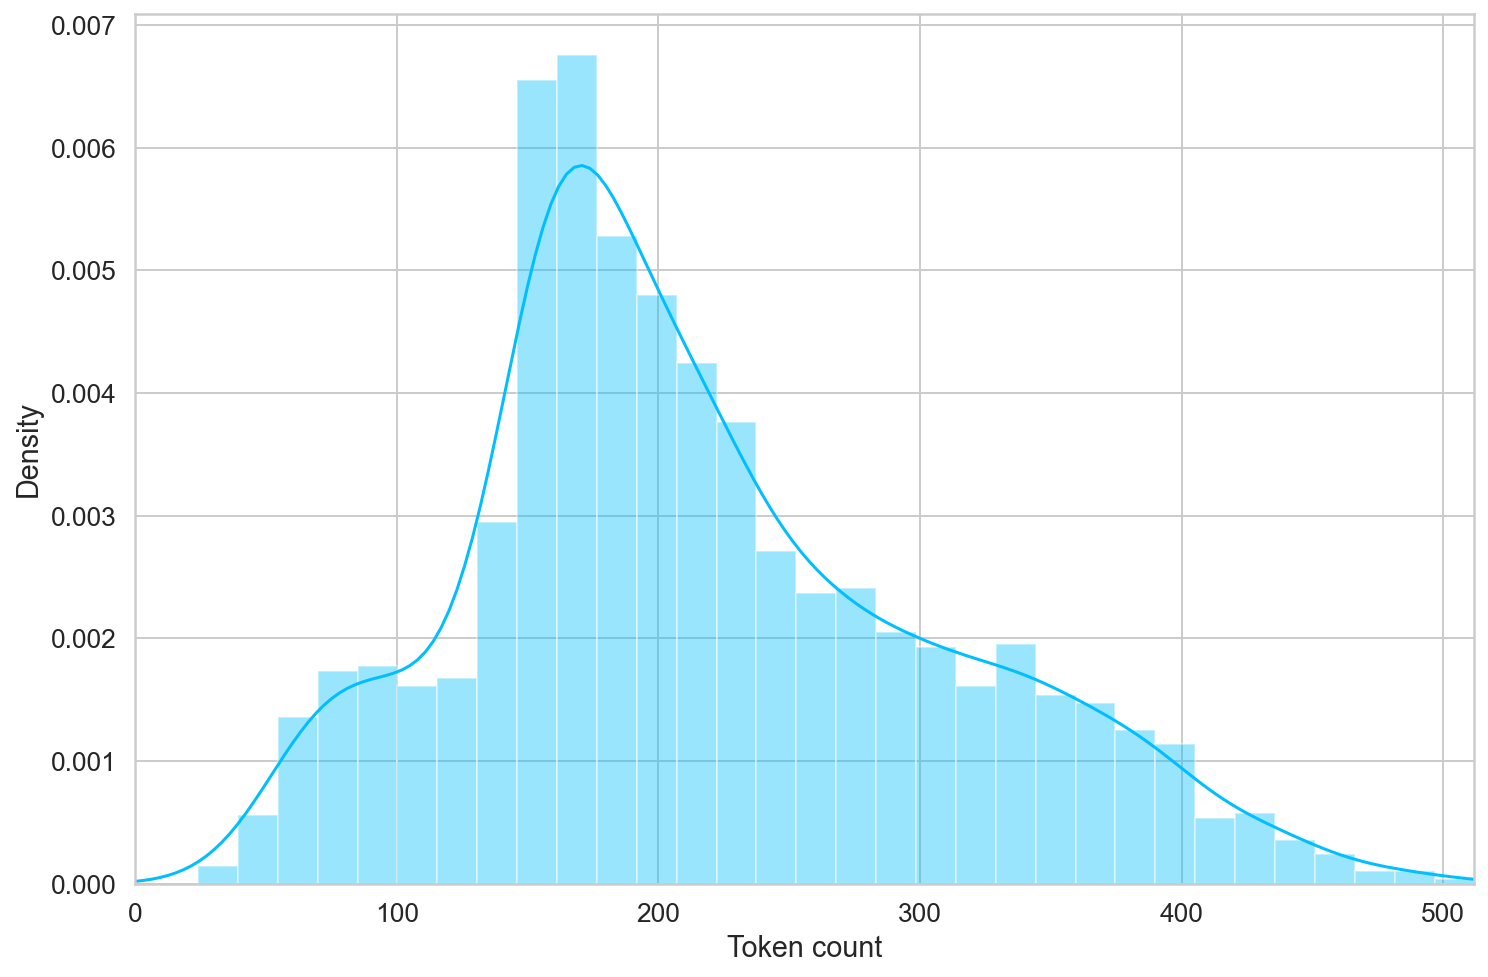

In [45]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 400 tokens, but we'll be on the safe side and choose a maximum length of 512.

In [46]:
#MAX_LEN = 512
#BATCH_SIZE = 8

MAX_LEN = 350
BATCH_SIZE = 16

#BATCH_SIZE = 4

### Create a Pytorch Dataset from the Pandas Dataframe

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

*   __len__ so that len(dataset) returns the size of the dataset.
*   __getitem__ to support the indexing such that dataset[i] can be used to get iith sample.



In [47]:
class IMDBDataset(Dataset):
  def __init__(self, pandas_dataframe):
    self.data_frame = pandas_dataframe


  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    item = self.data_frame.iloc[idx]

    if item['Sentiment'] == 'Positive':
      label = 1
    elif item['Sentiment'] == 'Negative':
      label = 0

    outputs = {'label': label,
               'text': item['Text'],
               }

    return outputs


In [48]:
# Let's test it out!

train_dataset = IMDBDataset(orig_train)

for idx in range(5):
  print(train_dataset[idx])

{'label': 0, 'text': 'Long, boring, blasphemous. Never have I been so glad to see ending credits roll.'}
{'label': 0, 'text': 'Not good! Rent or buy the original! Watch this only if someone has a gun to your head and then....maybe.<br /><br />It is like claiming an Elvis actor is as good as the real King.'}
{'label': 0, 'text': 'This movie is so bad, it can only be compared to the all-time worst "comedy": Police Academy 7. No laughs throughout the movie. Do something worthwhile, anything really. Just don\'t waste your time on this garbage.'}
{'label': 0, 'text': 'Spanish horrors are not bad at all, some are smart with interesting stories, but is not the case of "Second Name". It is badly directed, badly acted and boring...boring...boring, a missed chance for an interesting story.'}
{'label': 0, 'text': "I've seen about 820 movies released between 1931-39, and THE INFORMER is the worst major release I've seen from that time span. Awful, despicable, unpleasant, unhappy, unredeemable saga

In [49]:
for idx in range(1500,1505):
  print(train_dataset[idx])

{'label': 1, 'text': 'You spend most of this two-hour film wondering "what\'s the story regarding the lead character?" <br /><br />Will Smith, as a low-key "Ben Thomas" will keep you guessing. The last 20-25 minutes is when you find out, and it\'s a shocker....but you knew something dramatic was going to be revealed. Until then, Smith, plays it mysterious, almost stalking people. You know he has a good reason for doing it, but it\'s never really explained, once again, to keep us guessing until the end.<br /><br />All of it, including a on again/off again but touching romance with Rosario Dawkins ("Emily Posa") might make some viewers frustrated or wanting to quit this film.....but don\'t because the final long segment puts all the pieces of this puzzle together.<br /><br />This is a two-hour film and not the typical action-packed macho Will Smith film. In fact, the most shocking aspect might be seeing the drawn, sad face of Smith throughout this story. It almost doesn\'t even look like

### Using a Dataloader to Iterate through the Dataset
While we can use a simple for loop to iterate over the data, it is not the most efficient way. 

In particular, we are missing out on:

*   Batching the data
*   Shuffling the data
*   Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [50]:
# We'll create a Dataset for each split of the data:
orig_train_dataset = IMDBDataset(orig_train)
orig_val_dataset = IMDBDataset(orig_dev)
orig_test_dataset = IMDBDataset(orig_test)


In [51]:
# Remember we defined a tokenizer
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [52]:
def collate_batch(data):
    """
       data: a list of python dictionaries (with keys 'label' and 'text')
             
    """

    label_batch = [item['label'] for item in data]
    text_batch = [item['text'] for item in data]
    
    encoded = tokenizer.batch_encode_plus(text_batch, 
                                padding=True, 
                                add_special_tokens=True,
                                max_length=MAX_LEN,
                                truncation=True,
                                return_token_type_ids=False,                                
                                return_attention_mask=True,
                                return_tensors='pt',)

    encoded['targets'] = torch.tensor(label_batch)
    encoded['raw_text'] = text_batch

    return encoded

In [53]:
# Let's see the collate function in action
ex_inp = collate_batch([train_dataset[0], train_dataset[1]])

for key in ex_inp.keys():
  print(f"### {key} ###:\n\n", ex_inp[key], '\n\n')


### input_ids ###:

 tensor([[  101,  2146,  1010, 11771,  1010,  1038,  8523,  8458,  6633,  3560,
          1012,  2196,  2031,  1045,  2042,  2061,  5580,  2000,  2156,  4566,
          6495,  4897,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  2025,  2204,   999,  9278,  2030,  4965,  1996,  2434,   999,
          3422,  2023,  2069,  2065,  2619,  2038,  1037,  3282,  2000,  2115,
          2132,  1998,  2059,  1012,  1012,  1012,  1012,  2672,  1012,  1026,
          7987,  1013,  1028,  1026,  7987,  1013,  1028,  2009,  2003,  2066,
          6815,  2019, 12280,  3364,  2003,  2004,  2204,  2004,  1996,  2613,
          2332,  1012,   102]]) 


### attention_mask ###:

 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0

In [54]:
# We'll create a Dataloader for each split of the data. 

orig_train_dataloader = DataLoader(
        orig_train_dataset, shuffle=True, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )

orig_val_dataloader = DataLoader(
        orig_val_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )

orig_test_dataloader = DataLoader(
        orig_test_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )

print(f"Batch size: {BATCH_SIZE}")

Batch size: 16


Let's see how we can iterate through the Dataloader:

In [55]:
data = next(iter(orig_train_dataloader))
data

{'input_ids': tensor([[ 101, 3227, 2009,  ...,    0,    0,    0],
        [ 101, 2061, 2017,  ...,    0,    0,    0],
        [ 101, 1045, 5136,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 4156,  ...,    0,    0,    0],
        [ 101, 1045, 2219,  ...,    0,    0,    0],
        [ 101, 2023, 2003,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'targets': tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]), 'raw_text': ["Generally it was a good movie with an ideal ending; the acting was spectacular and the characters didn't stray from their persons. I especially liked the plot, although you knew what was going to happen it still gave the element of surprise through out the entire movie. However, I find that coming on to the ending it could have been a li

In [56]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 350])
torch.Size([16, 350])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

In this tutorial, we'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [57]:
example_bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading: 100%|██████████| 420M/420M [00:22<00:00, 19.8MB/s] 
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
# BERT is a Transformer, so its architecture is familiar to us:
example_bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [59]:
# Huggingface stores the architecture and other settings in a config class
example_bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

We can use our knowledge so far to create a classifier that uses the BERT model. Let's review some of the model components:

In [60]:
tokenizer.vocab_size

30522

In [61]:
# BERT is a Transformer, and works exactly as we saw before!
embedding_input = torch.randint(0,30522, size=(16, 50))
embedding_output = example_bert_model.embeddings(embedding_input)
embedding_output.size()

torch.Size([16, 50, 768])

In [62]:
bert_output = example_bert_model.encoder(embedding_output)
print(bert_output.last_hidden_state.size())
pprint(bert_output)

torch.Size([16, 50, 768])
{'last_hidden_state': tensor([[[ 0.2018,  0.0758,  0.2862,  ..., -0.2503,  0.0511, -0.0252],
         [ 0.3979,  0.1763,  0.1881,  ..., -0.1085, -0.1050, -0.0009],
         [ 0.5487,  0.1845,  0.1699,  ...,  0.0756,  0.1004,  0.4083],
         ...,
         [ 0.1466,  0.1512,  0.3002,  ..., -0.1918,  0.0109,  0.2423],
         [ 0.1931,  0.1471,  0.1697,  ..., -0.3147, -0.0871, -0.0116],
         [ 0.2593,  0.1871,  0.1196,  ..., -0.2450,  0.0019,  0.0825]],

        [[ 0.4637,  0.1925,  0.1720,  ..., -0.2318,  0.1491,  0.1792],
         [ 0.6196,  0.2634,  0.3858,  ..., -0.2496,  0.1483,  0.5022],
         [ 0.1651,  0.3080,  0.3968,  ..., -0.4163,  0.0825,  0.4659],
         ...,
         [ 0.5867,  0.1701,  0.3025,  ..., -0.3176,  0.0979,  0.1637],
         [ 0.7716,  0.1607,  0.3498,  ..., -0.1731,  0.0857,  0.2708],
         [ 0.6962,  0.1279,  0.1249,  ..., -0.2968,  0.1602,  0.1125]],

        [[ 0.2050,  0.2231,  0.3076,  ..., -0.1541,  0.2164,  0.1267

In [63]:
#bert_output['last_hidden_state'].size()
#bert_output[0].size()

### We build the Sentiment Classification model by attaching a classifier on top of BERT's output

In [64]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel, DistilBertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        #D_in, H, D_out = 768, 50, 2 # v1
        D_in, H, D_out = 768, 768, 2 # v2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        #self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Run the BERT model as before
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        #last_hidden_state_cls = outputs[0][:, 0, :] #v1
        last_hidden_state_cls = outputs['last_hidden_state'][:, 0, :] #v2

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: total: 93.8 ms
Wall time: 3.97 ms


### The training process for Transformers/BERT is a little more involved than NB.

We use an optimization process called **stochastic gradient descent**. Fortunately, the transformers library already implements the optimization algorithm which we can use easily (i.e Adam)!

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear [scheduler](https://huggingface.co/transformers/v3.0.2/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup) with no warmup steps:

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [65]:
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

def initialize_model(epochs=4, dataloader=None, freeze_bert=True):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=freeze_bert)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      #eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(dataloader) * epochs

    # Set up the learning rate scheduler
    #"""
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    #"""
    #scheduler = get_constant_schedule(optimizer)

    return bert_classifier, optimizer, scheduler

### The optimization process looks something like this:

The mountain-like surface is called the **loss-surface** of the neural network. 

Gradient descent attempts to find the network weights with the lowest loss, by updating the weights in such a way that we will move **a small step in the direction of steepest descent** at every iteration.

![Transformer model](https://miro.medium.com/max/1200/1*STiRp7PW5yIrvYZupZA6nw.gif)

In [66]:
#del model
#del input_ids, attention_mask
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Fri Jul 29 11:43:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8    14W /  N/A |   1522MiB /  8192MiB |     22%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

### Training

In [67]:
# This is not necessary but we can run the following lines again
orig_train_dataloader = DataLoader(
        orig_train_dataset, shuffle=True, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )

orig_val_dataloader = DataLoader(
        orig_val_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )

orig_test_dataloader = DataLoader(
        orig_test_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )

print(f"Batch size: {BATCH_SIZE}")

Batch size: 16


In [68]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, scheduler, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, ckpt_name="default"):
    """Train the BertClassifier model.
    """
    # Start training loop
    history = defaultdict(list)
    best_accuracy = 0

    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            #print(batch)
            #b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            b_input_ids = batch['input_ids'].to(device)
            b_attn_mask = batch['attention_mask'].to(device)
            b_labels = batch['targets'].to(device)
            #print(b_input_ids, b_attn_mask)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader, ckpt_name=None)

            #history['train_acc'].append(train_acc)
            #history['train_loss'].append(train_loss)
            history['val_acc'].append(val_accuracy)
            history['val_loss'].append(val_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)

            #"""
            if val_accuracy > best_accuracy:
              torch.save(model.state_dict(), f"{ckpt_name}_best_model_state.bin")
              print(f"New best checkpoint saved at {ckpt_name}_best_model_state.bin")
              best_accuracy = val_accuracy
            #"""
        print("\n")
    
    print("Training complete!")




Let's write another function that helps us evaluate the model on a given data loader:

In [69]:
def evaluate(model, val_dataloader, ckpt_name=None):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    if not ckpt_name is None:
      model.load_state_dict(torch.load(f"{ckpt_name}_best_model_state.bin"))
      print(f"Loaded weights from {ckpt_name}_best_model_state.bin")
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        #b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        b_input_ids = batch['input_ids'].to(device)
        b_attn_mask = batch['attention_mask'].to(device)
        b_labels = batch['targets'].to(device)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Using those two, we can write our training loop!

In [70]:
bert_classifier1, optimizer1, scheduler1 = initialize_model(epochs=2, dataloader=orig_train_dataloader, freeze_bert=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\AI_15\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is de

In [76]:
train(bert_classifier1, optimizer1, scheduler1, orig_train_dataloader, orig_val_dataloader, epochs=2, evaluation=True, ckpt_name='classifier1')

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 8.00 GiB total capacity; 6.15 GiB already allocated; 37.60 MiB free; 6.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [74]:
!nvidia-smi

Fri Jul 29 12:19:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P0    27W /  N/A |   7993MiB /  8192MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [75]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Fri Jul 29 12:19:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P0    27W /  N/A |   2217MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [ ]:
test_loss, test_accuracy = evaluate(bert_classifier1, orig_test_dataloader, ckpt_name='classifier1')
print(test_accuracy)

: 

In [ ]:
val_loss, val_accuracy = evaluate(bert_classifier1, orig_val_dataloader, ckpt_name='classifier1')
print(val_accuracy)

: 

In [ ]:
# Test accuracy is not too bad either: We've trained a decent classifier! :)
print('Val', round(val_accuracy,3))
print('Test', round(test_accuracy,3))

: 

## Counterfactual Data Augmentation

The dataset from [Learning the Difference that Makes a Difference with Counterfactually-Augmented Data](https://github.com/acmi-lab/counterfactually-augmented-data) provides counterfactually augmented data:

Given documents and their initial labels, the authors tasked humans to:
1.   Revise each document to accord with a counterfactual target label, subject to producing revisions that, 
2.   Result in internally consistent documents
3.   Avoids any gratuitous changes to facts that are semantically unrelated to the applicability of the label


In [ ]:
paired_train = pd.read_csv('/content/counterfactually-augmented-data/sentiment/combined/paired/train_paired.tsv', sep='\t', header=0)
paired_train.head()

: 

In [ ]:
# Now we'll use the counterfactually augmented data to train our model
combined_train = pd.read_csv('/content/counterfactually-augmented-data/sentiment/combined/train.tsv', sep='\t', header=0)
combined_val = pd.read_csv('/content/counterfactually-augmented-data/sentiment/combined/dev.tsv', sep='\t', header=0)

combined_train.info()

# We'll add the same amount of training data as before:
#overlap_combined_train = pd.concat([combined_train, extra_train])
#nonoverlap_combined_train = overlap_combined_train.drop_duplicates(keep=False)
#to_add_combined = nonoverlap_combined_train.sample(len(combined_train))
#combined_train = pd.concat([combined_train, to_add_combined])

# We'll add the same amount of training data as before:
combined_train = pd.concat([combined_train, to_add])
combined_train.drop_duplicates(inplace=True)

# Sample half
#combined_train = combined_train.sample(frac=0.5)

combined_train_dataset = IMDBDataset(combined_train)
combined_val_dataset = IMDBDataset(combined_val)

# We'll create a Dataloader for each split of the data. 
combined_train_dataloader = DataLoader(
        combined_train_dataset, shuffle=True, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )
combined_val_dataloader = DataLoader(
        combined_val_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )



: 

In [ ]:
combined_train.info()

: 

In [ ]:
# Train on orig + cf data
bert_classifier2, optimizer2, scheduler2 = initialize_model(epochs=2, dataloader=combined_train_dataloader, freeze_bert=False)
train(bert_classifier2, optimizer2, scheduler2, combined_train_dataloader, combined_val_dataloader, epochs=2, evaluation=True, ckpt_name='classifier2')

: 

In [ ]:
test_loss, test_accuracy = evaluate(bert_classifier2, orig_test_dataloader, ckpt_name='classifier2')
val_loss, val_accuracy = evaluate(bert_classifier2, orig_val_dataloader, ckpt_name='classifier2')
# Test accuracy is not too bad either: We've trained a decent classifier! :)
print('Val', round(val_accuracy,3))
print('Test', round(test_accuracy,3))

: 

## Evaluation on Out-of-domain Data

So how good is our model on predicting sentiment on various types of **out-of-domain** data?

In [77]:
# We will test our classifiers on the counterfactually augmented test set

cf_test = pd.read_csv('/content/counterfactually-augmented-data/sentiment/new/test.tsv', sep='\t', header=0)
#cf_test = pd.read_csv('/content/counterfactually-augmented-data/sentiment/combined/test.tsv', sep='\t', header=0)

# We'll create a Dataset for each split of the data:
cf_test_dataset = IMDBDataset(cf_test)

# We'll create a Dataloader for each split of the data. 
cf_test_dataloader = DataLoader(
        cf_test_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )

cf_val = pd.read_csv('/content/counterfactually-augmented-data/sentiment/new/dev.tsv', sep='\t', header=0)
#cf_test = pd.read_csv('/content/counterfactually-augmented-data/sentiment/combined/test.tsv', sep='\t', header=0)

# We'll create a Dataset for each split of the data:
cf_val_dataset = IMDBDataset(cf_val)

# We'll create a Dataloader for each split of the data. 
cf_val_dataloader = DataLoader(
        cf_val_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )


FileNotFoundError: [Errno 2] No such file or directory: '/content/counterfactually-augmented-data/sentiment/new/test.tsv'

In [ ]:
# We will also test on an out-of-domain dataset, SST2 Movie Reviews from GLUE

# First we should convert the data to the format we've been using:
def convert_sst2():

  converted = pd.DataFrame(columns=["Sentiment","Text"])

  for item in tqdm.tqdm(sst2_dataset['validation'], desc='Converting SST2 validation data'):
    #print(item)
    if item['label'] == 1:
      label = 'Positive'
    elif item['label'] == 0:
      label = 'Negative'
    converted.loc[len(converted)] = [label, item['sentence']]
    #1
  return converted

sst2_val = convert_sst2()
# We'll create a Dataset for each split of the data:
sst2_val_dataset = IMDBDataset(sst2_val)

# We'll create a Dataloader for each split of the data. 
sst2_val_dataloader = DataLoader(
        sst2_val_dataset, shuffle=False, collate_fn=collate_batch, batch_size=BATCH_SIZE
    )


: 

In [ ]:
# Let's see some samples from SST2
for ii in range(5):
  print(sst2_val_dataset[ii])

: 

In [ ]:
# What do samples from IMDB look like?
sample_ids = random.sample(range(len(orig_test_dataset)), 5)
for ii in sample_ids:
  print(orig_test_dataset[ii])

: 

In [ ]:
# Let's compare the two classifiers

for dataset_name, evaluation_dataloader in [('IMDB Original', orig_test_dataloader), ('IMDB Counterfactual', cf_test_dataloader), ('GLUE SST2 Movie Reviews', sst2_val_dataloader)]:
  _, c1_acc = evaluate(bert_classifier1, evaluation_dataloader, ckpt_name='classifier1')
  _, c2_acc = evaluate(bert_classifier2, evaluation_dataloader, ckpt_name='classifier2')
  print(f"\n{dataset_name} accuracy - Classifier 1: {round(c1_acc,3)}, Classifier 2: {round(c2_acc,3)}\n")


: 

In [ ]:
# We can also load our pretrained ckpts
from google.colab import drive
drive.mount('/content/drive')
#drive_url="https://drive.google.com/drive/folders/15DtQTuOHeG-pwGsQ1PFUgiTg2Hj7CcQ9?usp=sharing"
!ls /content/drive/MyDrive/jul23_tutorial/

!rm "./classifier1_best_model_state.bin"
!rm "./classifier2_best_model_state.bin"
!cp "/content/drive/MyDrive/jul23_tutorial/classifier1_best_model_state.bin" "./"
!cp "/content/drive/MyDrive/jul23_tutorial/classifier2_best_model_state.bin" "./"

: 

In [78]:
# Let's compare the two classifiers

for dataset_name, evaluation_dataloader in [('IMDB Original', orig_test_dataloader), ('IMDB Counterfactual', cf_test_dataloader), ('GLUE SST2 Movie Reviews', sst2_val_dataloader)]:
  _, c1_acc = evaluate(bert_classifier1, evaluation_dataloader, ckpt_name='classifier1')
  _, c2_acc = evaluate(bert_classifier2, evaluation_dataloader, ckpt_name='classifier2')
  print(f"{dataset_name} accuracy - Classifier1: {c1_acc}, Classifier2: {c2_acc}")


NameError: name 'cf_test_dataloader' is not defined

Of the two classifiers, Classifier 2 (the one trained with counterfactually augmented data) seems to perform better on out-of-domain data!

## Predictions on Raw Text

Let's use our models to classify the examples from before:

In [ ]:
def predict(model, val_dataloader, ckpt_name=None):
    """Use a trained model to classify the sentiment of a text.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    if not ckpt_name is None:
      model.load_state_dict(torch.load(f"{ckpt_name}_best_model_state.bin"))
      print(f"Loaded weights from {ckpt_name}_best_model_state.bin")
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        #b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        b_input_ids = batch['input_ids'].to(device)
        b_attn_mask = batch['attention_mask'].to(device)
        b_labels = batch['targets'].to(device)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

: 

In [ ]:
# We'll tokenize the text directly

def tokenization_encode(text):

  encoded = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  return encoded

: 

In [ ]:
# Let's define the inference function

def inference(ckpt_name, model, text):

  model.load_state_dict(torch.load(f"{ckpt_name}_best_model_state.bin"))
  print(f"Loaded weights from {ckpt_name}_best_model_state.bin")
  model.eval()

  encoded = tokenization_encode(text)

  input_ids = encoded['input_ids'].to(device)
  attention_mask = encoded['attention_mask'].to(device)

  with torch.no_grad():
    logits = model(input_ids, attention_mask)

  # Get the prediction
  pred = torch.argmax(logits, dim=1).flatten()

  #_, prediction = torch.max(output, dim=1)

  if pred.cpu().item() == 0:
    pred = 'Negative'
  elif pred.cpu().item() == 1:
    pred = 'Positive'

  return pred

: 

In [ ]:
example_text1 = "Nolan paints an inky portrait of a city falling apart, and in a movie rife with two-faced masquerading freaks, the Joker is merely the least conflicted of the bunch. Ledger's work is improbably droll, impossibly creepy, meticulously detailed. See for yourself."
example_text2 = "My favorite pits Bale's Batman and his \"Bat-Pod,\" the world's deadliest, most awesome motorcycle, against Ledger's Joker in an 18-wheeler. The setting is Chicago's LaSalle Street canyon, and what I love about the scene -- aside from its eerie, 3 a.m. vibe -- is Nolan's reliance on good old-fashioned stunt work."
example_text3 = "This movie is just so flat and claustrophobic... in those moments when a little flair is called for it feels incongruous - whenever Anne Hathaway would smirk off one of her half-hearted one-liners I felt as if I'd switched channels for a second. It's too bad because Hathaway wasn't bad and fit Selina into the Nolan world better than she might've, but any stabs at lightness here just had no place."
example_text4 = "As befits the saga's engagement with the economics of Gotham City, a great deal of topical material floats about here, insufficiently digested."
example_text5 = "Nolan has become hooked on the grandiose, at times even the biblical. For anyone who admired the witty playfulness of his early films, it's a dark night indeed."

for text in [example_text1, example_text2, example_text3, example_text4, example_text5]:
  c1_pred = inference('classifier1', bert_classifier1, text)
  c2_pred = inference('classifier2', bert_classifier2, text)
  print(f'\n## Review text ##\n{text}')
  print(f'\nClassifier 1 Prediction : {c1_pred}')
  print(f'Classifier 2 Prediction : {c2_pred}')

: 

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

: 

In [ ]:
# Let's try using another pre-trained model from Huggingface
from transformers import pipeline
model_path = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

: 

In [ ]:
# Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive
for text in [example_text1, example_text2, example_text3, example_text4, example_text5]:
  res = sentiment_task(text)[0]
  if res['label'] == 'LABEL_0':
    label = 'Negative'
  elif res['label'] == 'LABEL_1':
    label = 'Neutral'
  elif res['label'] == 'LABEL_2':
    label = 'Positive'
  print(f"Text: {text[:200]}")
  print(f"Label: {label}, Score: {round(res['score'],3)}\n")

: 

In [ ]:
# https://huggingface.co/bigscience/T0pp

: 

## Summary

Nice job! You learned how to use BERT for sentiment analysis. You built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Next, we'll learn how to deploy our trained model behind a REST API and build a simple web app to access it.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

: 